## SingleTopic Embeddings

The assumption that a document belongs only to one topic simplifies the model without losing generalization.

After assigning documents to the topics, the 8semantic embeddings* of the documents can be calculated by the matrix $H$ where element $_H{ij}$ shows the probability of assigning document $i$ to the topic $j$. For brevity, this embedding assumes each document is assigned to only one topic:

$$
\text{\ documents} \xmapsto{\text{USEv4}}
\vec{X} \xmapsto{\text{UMAP}}
\vec{U} \xmapsto{\text{HDBSCAN}}
\vec{\cnums},\vec{W}\xmapsto{\text{one-hot}}
\vec{Z}\xmapsto{\text{pool}}
\vec{H}\xmapsto{\text{GNN}} \vec{G}
$$

$$
\begin{align*}
Z_{ij} &= \begin{cases}W_i & \text{if }\ \cnums_i=j \ \text{(document } i \text{ is in cluster } j \text{)}\\0 &\text{otherwise}
\end{cases}

\\ \\
H_{kj} &= \sum_{i\  \in\ L_k} Z_{ij} \ \ \  \text{(sum-pooling)}

\\ \\
|\vec{X}| &= N_{\text{documents}} \times 768\\|\vec{U}| &= N_{\text{documents}}\times 5\\|\vec{\cnums}| &= |\vec{W}| = N_{\text{documents}} \times 1 \\|\vec{Z}| &= N_{\text{documents}} \times N_{\text{clusters}}\\|\vec{H}| &= (N_{\text{tasks}} + N_{\text{constructs}})\ \times \ N_{\text{clusters}}
\end{align*}
$$

where $Z_i$ is a single-entry vector where the only non-zero element at index $j$ shows the probability of assigning the document $i$ to the topic $j$. $H_{i}$ is the topics membership vector for the document $i$ as generated by HDBSCAN during the topic modeling; element $H_{ij}$ shows the probability of assigning document $i$ to the topic $j$. Note that $\sum_{j} H_{ij} = 1$ does not always hold.

Consequently, the topic embeddings $Z$ of a document set $L_j$ is calculated by pooling the embeddings of its member documents.

$$\overrightarrow Z_{L_j} = \sum_{i \in L_j} \overrightarrow  Z_{i}$$

where $L_j$ is a list of document indices, and $Z_{L_j}$ is the embedding for the label $j$ in the topics space.

In [37]:
# Install requirements
%pip install -Uq matplotlib seaborn xmltodict sklearn "umap-learn[parametric_umap]"
%pip install -Uq git+https://github.com/scikit-learn-contrib/hdbscan

# Creating a new conda env is highly recommended because of the conflicting packages.
# %conda activate bertopic

Note: you may need to restart the kernel to use updated packages.


In [ ]:

# Setup and imports

%reload_ext autoreload
%autoreload 2

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
from hdbscan import HDBSCAN
import joblib
from sklearn.metrics.pairwise import cosine_similarity

from python.cogtext.datasets.pubmed import PubMedDataLoader

In [ ]:
data_loader = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=False)
data = data_loader()
# DEBUG data = data.sample(frac=.01, random_state=42)

In [ ]:
# pretrained document embeddings
doc_embeddings_file = 'models/universal-sentence-encoder-v4/abstracts_embeddings.npz'
# doc_embeddings_file = 'models/all-MiniLM-L6-v2/abstracts_embeddings.npz'

umap_embeddings_file = 'models/umap/abstracts_embeddings_USE-v4-5d.npz'

X = np.load(doc_embeddings_file)['arr_0']
X = X[data.index]

# OR refit the document embedding model from scratch
# doc_embedding_model = SentenceTransformer('all-distilroberta-v1')
# X = doc_embedding_model.encode(X, show_progress_bar=True)

# y = data['label'].astype('category').cat.codes

In [ ]:
joblib_cache = joblib.Memory(location='tmp')

# reduce dimensionality with UMAP
if not Path(umap_embeddings_file).exists():
  from umap import UMAP
  reducer = UMAP(n_neighbors=15,
                 n_components=5,
                 min_dist=0.0,
                 metric='cosine',
                 verbose=True,
                 n_jobs=1,
                 low_memory=True)

  reduced_embeddings = reducer.fit_transform(X)
  reduced_embeddings = np.nan_to_num(reduced_embeddings)

else:
  # load the UMAP embedding from the cached model
  reduced_embeddings = np.load(umap_embeddings_file)['arr_0']

print('[UMAP] Reduced dimensionality of the document vectors.')

# Cluster documents with HDBSCAN
clusterer = HDBSCAN(min_cluster_size=10,
                    min_samples=1,
                    metric='euclidean',
                    core_dist_n_jobs=1,
                    memory=joblib_cache,
                    prediction_data=True)

clusters = clusterer.fit_predict(reduced_embeddings)
cluster_probs = clusterer.probabilities_

data['topic'] = clusters
data['topic_score'] = cluster_probs
data['topic'].replace({-1:np.nan}, inplace=True)  # discard noise clusters

print('[HDBSCAN] Successfully clustered documents.')

[UMAP] Reduced the dimensionality of the document vectors.
[HDBSCAN] Clustered documents.


In [ ]:
def fit_umap():
  pass

def fit_hdbscan():
  pass

def calculate_topic_vectors():
  pass

def merge_similar_topics():
  # perform hdbscan and combine topics if they are clustered together
  pass

def calculate_topic_vectors():
  pass

def generate_topic_names():
  # TODO tf-idf
  pass

/usr/local/Caskroom/miniforge/base/envs/bertopic/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


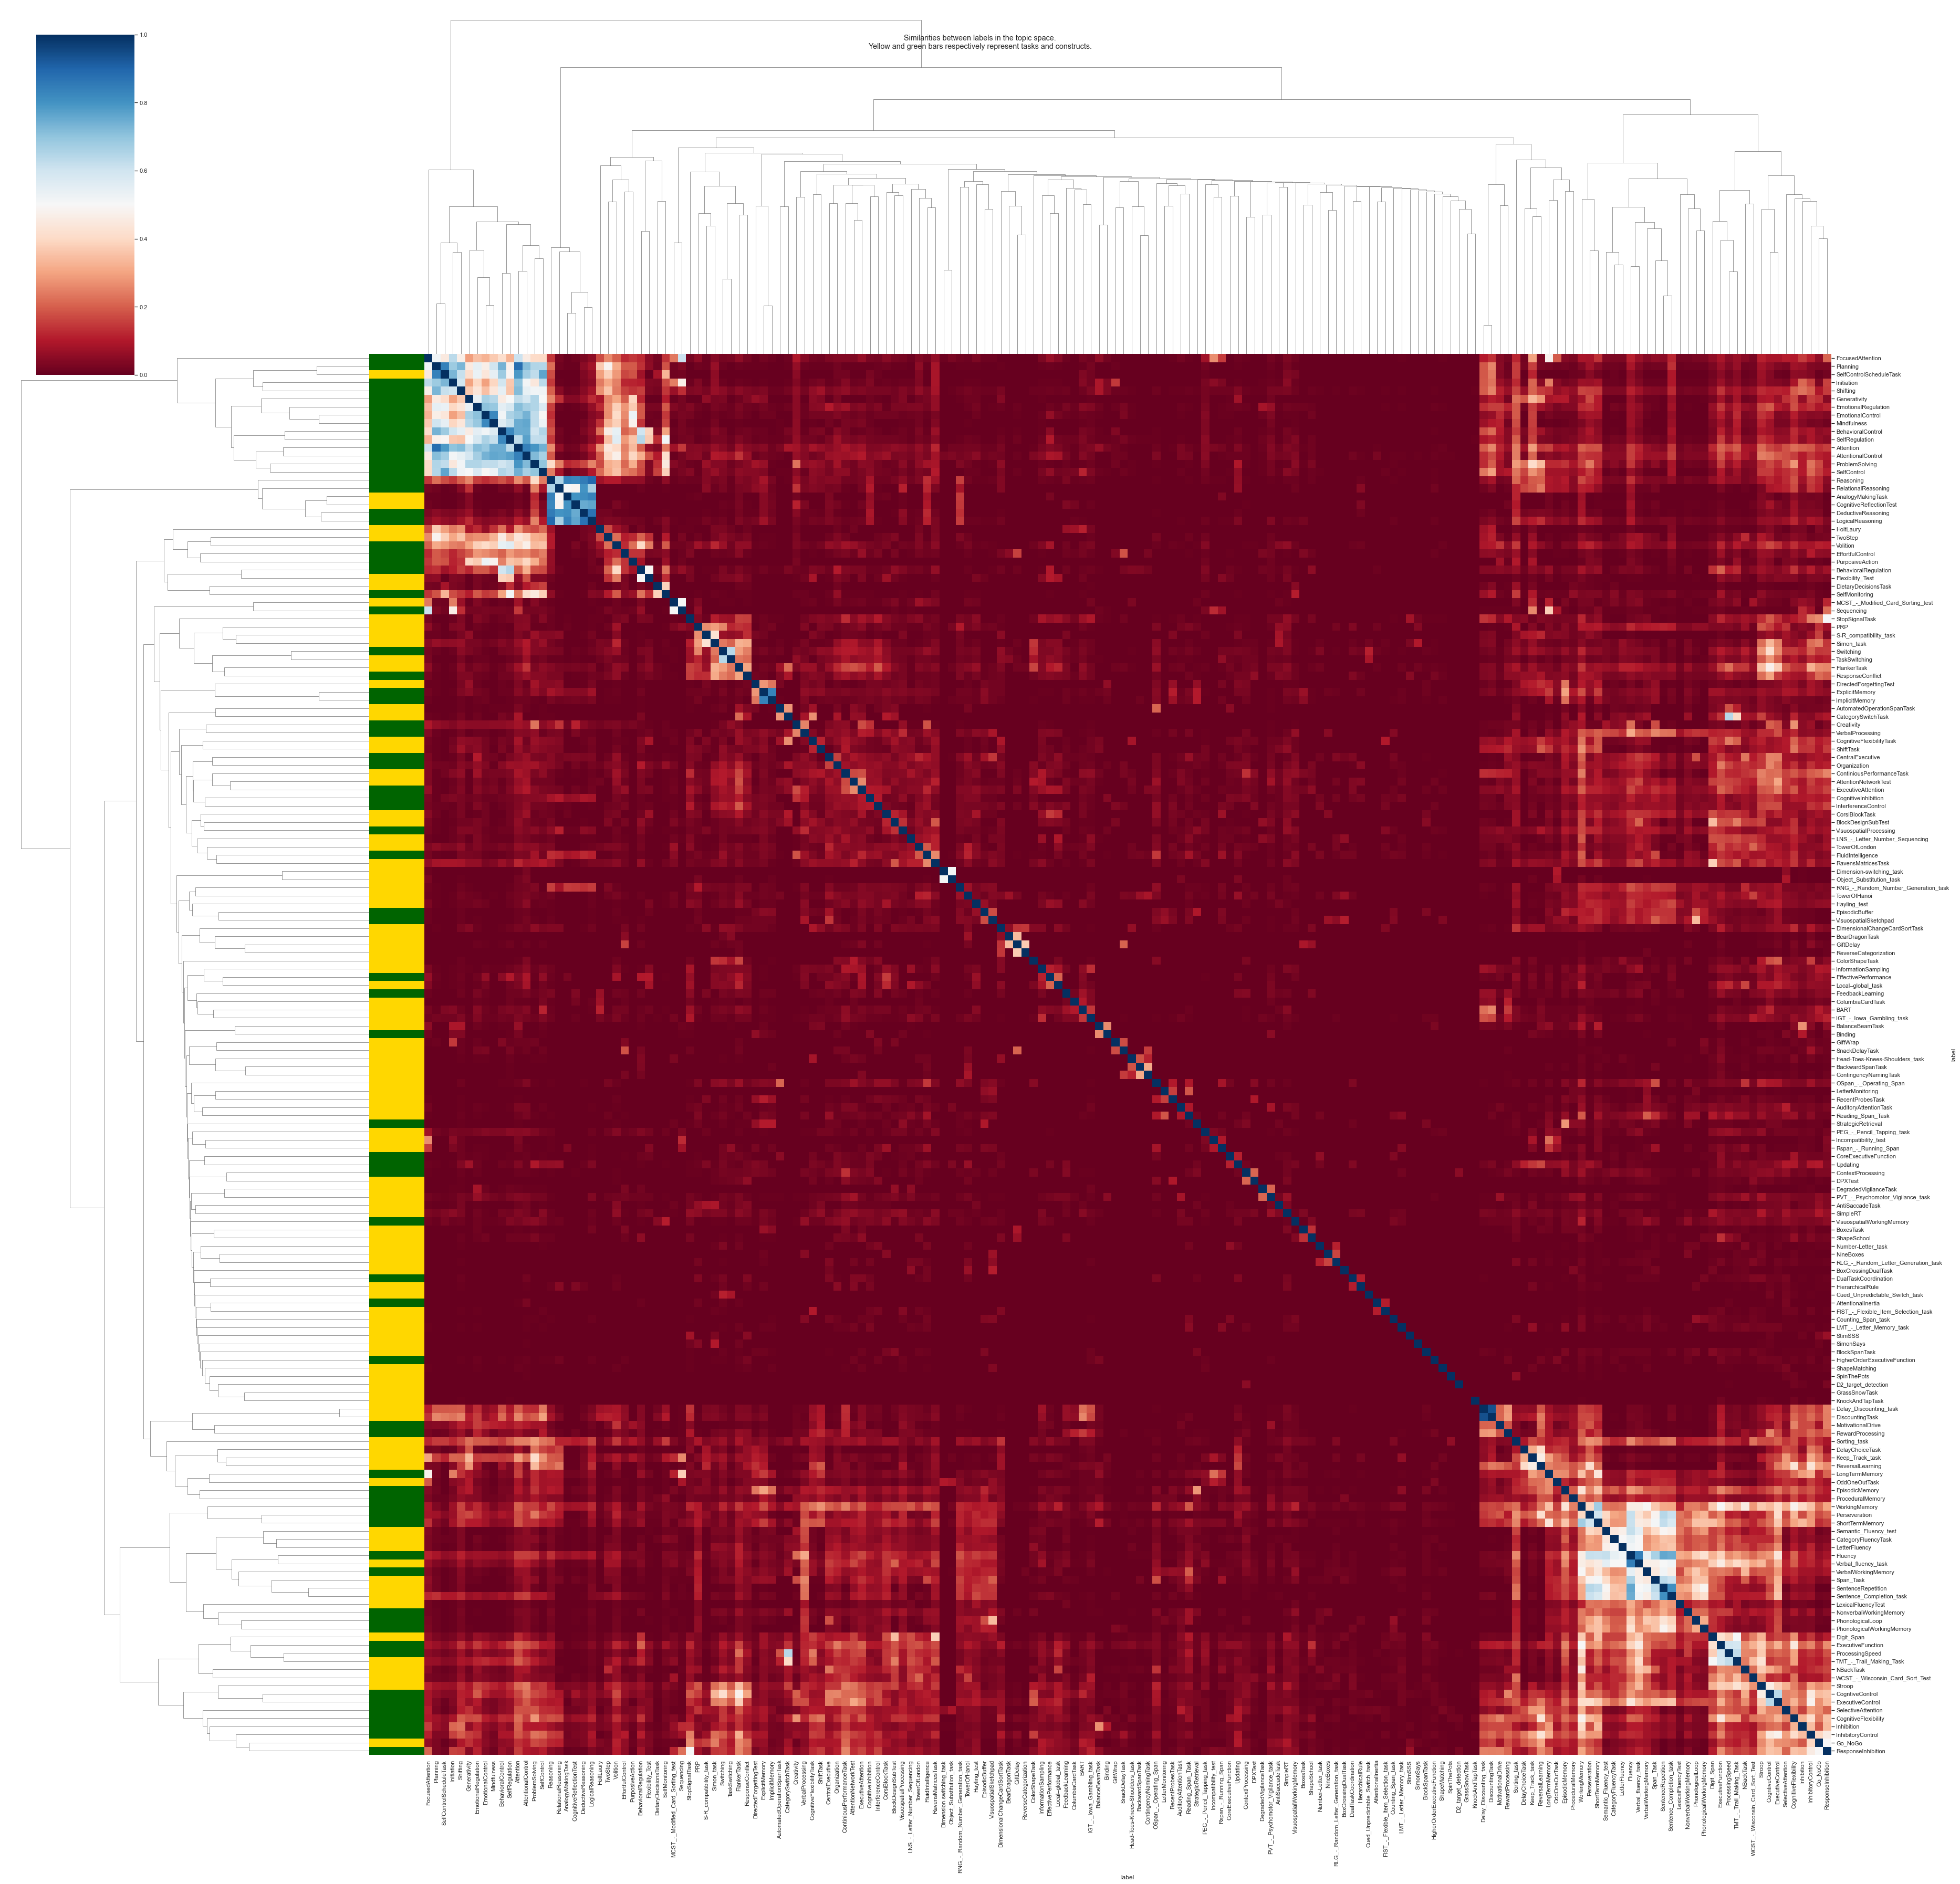

In [ ]:
n_topics = data['topic'].nunique() # discard the -1 cluster (missing values)
n_docs = data.shape[0]

Z = np.zeros((n_docs, n_topics))

for i, _, topic, score in data[['topic','topic_score']].reset_index().itertuples():
  if pd.notna(topic):
    Z[i, int(topic)] = score

# DEBUG confirm that non-zero element is valid and that one-hot encoding works as expected
# assert all(Z.sum(axis=1) == data['topic_score'])
# assert all((Z.argmax(axis=1) == data['topic']) | not data['topic'].ina())

Z = pd.DataFrame(Z, index=data.index)
Z = Z.groupby(data['label']).sum()

# cosine similarity
Z_sim = pd.DataFrame(cosine_similarity(Z), index=Z.index, columns=Z.index)

# mark rows by color
cats = Z_sim.index.to_series().apply(
  lambda x: data.query('label == @x').iloc[0]['category'])
pallette = ['darkgreen', 'gold']
colors = [pallette[c] for c in cats.astype('category').cat.codes.to_list()]

# plot clustered heatmap
sns.clustermap(Z_sim, figsize=(52,50), cmap='RdBu', row_colors=colors)
plt.suptitle('Similarities between labels in the topic space.\n'
             'Yellow and green bars respectively represent tasks and constructs.')
plt.show()

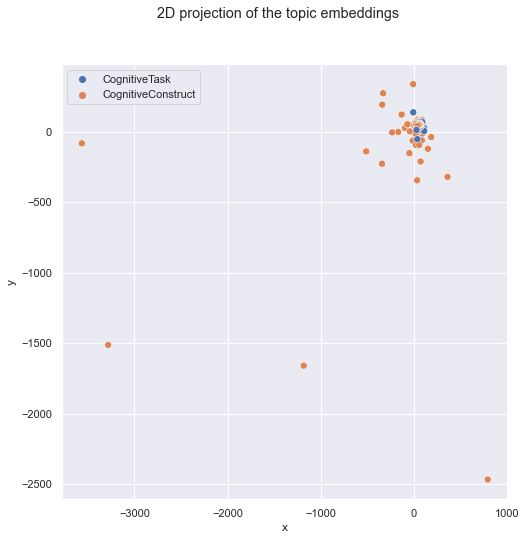

In [ ]:
# project topic embeddings to 2d and plot

from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from umap import UMAP

projector = MDS(n_components=2) # TSNE, PCA, MDS, UMAP

Z_2d = projector.fit_transform(Z)
Z_2d = pd.DataFrame(Z_2d, index=Z.index, columns=['x', 'y']).reset_index()

colors =  [c for c in cats.astype('category')]

_, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(x='x', y='y', data=Z_2d, hue=colors, ax=ax, s=50)
plt.suptitle('2D projection of the topic embeddings')
plt.show()